<a href="https://colab.research.google.com/github/mnwato/nlp-projects/blob/master/Paraphrase%20Identification%20using%20Siamese%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Define prams

In [24]:
# Set it to be True if you want to use pretraine Models
usePretrainedModel = True

# Download and load data

## Download

In [13]:
# Download train, valid, test data
!gdown --id 17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
!gdown --id 1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
!gdown --id 1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr

# Download pretrained embedding
!gdown --id 1-6eFo8BJxG-_tH-ErDFCvkbk9cqfatzr
!unzip *\zip

Downloading...
From: https://drive.google.com/uc?id=17eLq5Ng5yfbX9tLq2tdiOdscO0ea8xK5
To: /content/train.csv
100% 951k/951k [00:00<00:00, 60.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y-68UagW14hwJXNyaR2HnML5jEwvjQlj
To: /content/valid.csv
100% 105k/105k [00:00<00:00, 38.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P_HLLvGq15gsgDl5P6QYrHkTlkcytMdr
To: /content/test.csv
100% 444k/444k [00:00<00:00, 59.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6eFo8BJxG-_tH-ErDFCvkbk9cqfatzr
To: /content/data.zip
100% 10.3M/10.3M [00:00<00:00, 90.1MB/s]
Archive:  data.zip
replace BiLSTM-1631371335model-20-0.690.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: BiLSTM-1631371335model-20-0.690.hdf5  
replace GRU-1631369260model-20-0.683.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: GRU-1631369260model-20-0.683.hdf5  
replace LSTM-1631368803model-15-0.688.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: LSTM-1631368803model-1

## load

In [14]:
from gensim.models import Word2Vec
import pandas as pd

df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
df_valid = pd.read_csv('/content/valid.csv')
columns=['label', 'id1', 'id2', 'sentence1', 'sentence2']

df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_valid = df_valid.drop(columns=['Unnamed: 0'])

df_train.columns=columns
df_test.columns=columns
df_valid.columns=columns

df_train.head(2)

,label,id1,id2,sentence1,sentence2
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...


plot number of labels

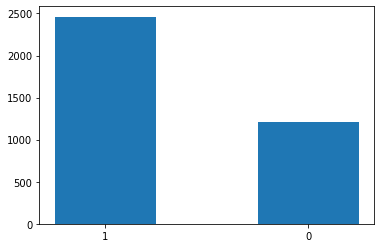

In [15]:
# plot number of labels
from matplotlib import pyplot as plt
one, zero = df_train['label'].value_counts()

plt.bar(['1','0'], [one, zero], width=0.5)
plt.show()

## data cleaning

In [16]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# nltk.download('stopwords')

# Define embedding arguments
embedding_dim = 100
max_length = 17
trunc_type='post'
padding_type='post'


# Text cleaner function
def clean(dataframe):
  dataframe[['cleanedSent1', 'cleanedSent2']] = None
  for i in range(len(dataframe)):
      tokens1 = word_tokenize(dataframe['sentence1'].iloc[i])
      tokens2 = word_tokenize(dataframe['sentence2'].iloc[i])
      # remove all tokens that are not alphabetic
      dataframe['cleanedSent1'].iloc[i] = ' '.join([word for word in tokens1 if word.isalpha()])
      dataframe['cleanedSent2'].iloc[i] = ' '.join([word for word in tokens2 if word.isalpha()])
  return dataframe

df_train = clean(df_train)
df_test = clean(df_test)
df_valid = clean(df_valid)
df_train.head(2)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,label,id1,id2,sentence1,sentence2,cleanedSent1,cleanedSent2
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi...",Amrozi accused his brother whom he called the ...,Referring to him as only the witness Amrozi ac...
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...,Yucaipa owned Dominick before selling the chai...,Yucaipa bought Dominick in for million and sol...


In [17]:
# Text tokenization and sequence padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess(input_list):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(input_list)
  word_index = tokenizer.word_index
  vocab_size = len(word_index)
  print(vocab_size)
  sequences = tokenizer.texts_to_sequences(input_list)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return padded, word_index


sent1Padded = preprocess(input_list=df_train['cleanedSent1'])[0]
sent2Padded = preprocess(input_list=df_train['cleanedSent2'])[0]
xtrain = [sent1Padded] + [sent2Padded]
ytrain = df_train['label'].values

sent1Padded = preprocess(input_list=df_test['cleanedSent1'])[0]
sent2Padded = preprocess(input_list=df_test['cleanedSent2'])[0]
xtest = [sent1Padded] + [sent2Padded]
ytest = df_test['label'].values

sent1Padded = preprocess(input_list=df_valid['cleanedSent1'])[0]
sent2Padded = preprocess(input_list=df_valid['cleanedSent2'])[0]
xvalid = [sent1Padded] + [sent2Padded]
yvalid = df_valid['label'].values

print(len(xtrain), len(xtrain[0]))
print('size of train:{}, test:{}, valid:{}'.format(xtrain[0].shape,
                                                   xtest[0].shape,
                                                   xvalid[0].shape))

9994
9937
6677
6655
2630
2620
2 3669
size of train:(3669, 17), test:(1725, 17), valid:(407, 17)


## load pretrained embedding

In [18]:
# Load Pretrained embedding
import numpy as np

emb_path = r'/content/w2v_100d.txt'

word_index = preprocess(input_list=df_train['cleanedSent1'])[1]
vocab_size = len(word_index)

embeddings_index = {}
with open(emb_path, encoding='utf-8') as f:
    content = f.readlines()
    for line in content[1:]:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

print('number of unique words in pretrained emb:', len(embeddings_index))
print('vocab size:', vocab_size)
print('number of unique words in current emb(extracted from pretrained emb):', embeddings_matrix.shape)
print('number of sentences in corpus:', len(df_train))

9994
number of unique words in pretrained emb: 6830
vocab size: 9994
number of unique words in current emb(extracted from pretrained emb): (9995, 100)
number of sentences in corpus: 3669


Define callback

In [19]:
# The PlotLosses function, plots the validation and training loss function during the
#  training to give an insight of training the model
import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.val_accuracy.append(logs.get('val_accuracy'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.grid()
        plt.show()
        plt.plot(self.x, self.accuracy, label="accuracy")
        plt.plot(self.x, self.val_accuracy, label="val_accuracy")
        plt.legend()
        plt.grid()
        plt.show()

        print('Validation metrics:')
        print('val_losses: {}'.format(round(self.val_losses[-1], 3)),
        'val_accuracy: {}'.format(round(self.val_accuracy[-1], 3)) )

plot_losses = PlotLosses()

# define Model

In [20]:
# keras imports
from keras.layers import Dense, Input, LSTM, GRU, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.callbacks import TensorBoard
from keras.models import load_model
from keras.models import Model
from keras.layers import Layer
import keras.backend as K

nb_words = len(word_index) + 1


# Define attenstion class
class attention(Layer):
  global w, b
  def __init__(self,**kwargs):
    super(attention,self).__init__(**kwargs)

  def build(self,input_shape):
    global w, b
    self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
    self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
    super(attention, self).build(input_shape)
    w = self.W
    b = self.b
    return self.W, self.b

  def weightss(self): # تابع مربوط به دریافت وزن های لایه توجه
    global w, b
    return w, b

  def call(self,x):
    et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
    at=K.softmax(et)
    at=K.expand_dims(at,axis=-1)
    output=x*at
    return K.sum(output,axis=1)

  def compute_output_shape(self,input_shape):
    return (input_shape[0],input_shape[-1])

  def get_config(self):
    return super(attention,self).get_config()



# Define model
def defined_model(RNN_layer):

  # Creating word embedding layer
  embedding_layer = Embedding(nb_words, embedding_dim, weights=[embeddings_matrix],
                              input_length=max_length, trainable=False)

  # Attention
  att = attention()

  # Creating LSTM Encoder
  if RNN_layer == 'BiLSTM':
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))#, dropout=0, recurrent_dropout=0))
  elif RNN_layer == 'LSTM':
    lstm_layer = LSTM(128, return_sequences=True)#, dropout=0, recurrent_dropout=0))
  elif RNN_layer == 'GRU':
    lstm_layer = GRU(128, return_sequences=True)#, dropout=0, recurrent_dropout=0))
  else:
    raise Exception("""
    RNN_layer argument is not correct.
      choose one of the following layers:
      1- BiLSTM
      2- LSTM
      3- GRU
      """)

  # Creating LSTM Encoder layer for First Sentence
  sequence_1_input = Input(shape=(max_length,), dtype='int32')
  embedded_sequences_1 = embedding_layer(sequence_1_input)
  att_in1 = lstm_layer(embedded_sequences_1)
  att_out1 = att(att_in1)

  # Creating LSTM Encoder layer for Second Sentence
  sequence_2_input = Input(shape=(max_length,), dtype='int32')
  embedded_sequences_2 = embedding_layer(sequence_2_input)
  att_in2 = lstm_layer(embedded_sequences_2)
  att_out2 = att(att_in2)


  # Merging two attention encodes vectors from sentences
  merged = concatenate([att_out1, att_out2])
  merged = Dense(256, activation='relu')(merged)
  merged = Dense(128, activation='relu')(merged)
  preds = Dense(1, activation='sigmoid')(merged)

  model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

# چاپ خلاصه مدل
defined_model(RNN_layer='BiLSTM').summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 17, 100)      999500      input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 17, 256)      234496      embedding_3[0][0]          

## Plot model

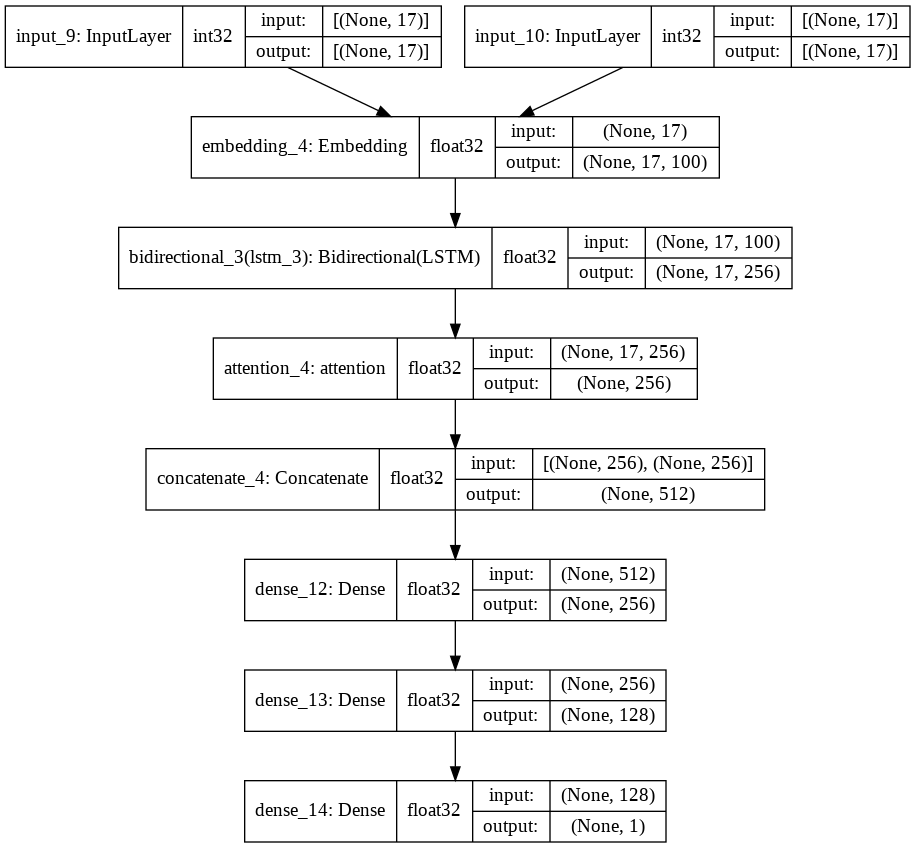

In [21]:
import tensorflow as tf
model = defined_model(RNN_layer='BiLSTM')
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

## Define model fiiting function then train usign created model

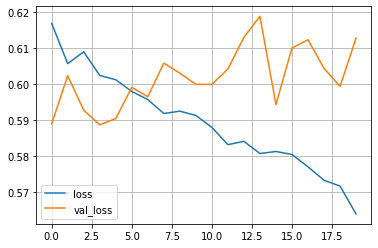

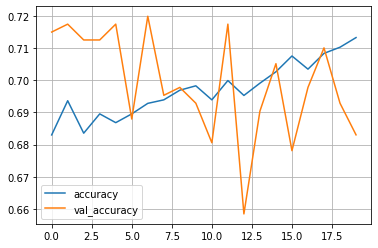

Validation metrics:
val_losses: 0.613 val_accuracy: 0.683
Training Complete




In [25]:
from keras.callbacks import ModelCheckpoint
# std imports
import time
# import gc
import os

# Model fitting
def fitting(RNN_layer, epoch=10, batch_size=128):
  model = defined_model(RNN_layer = RNN_layer)

  checkpoint_dir = r'/content/checkpoints/'
  checkpoint_name = str(int(time.time())) + 'model-{epoch:02d}-{val_accuracy:.3f}.hdf5'

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpoint = ModelCheckpoint(checkpoint_dir + checkpoint_name,
                              monitor='val_accuracy',
                              save_weights_only=True,
                              save_best_only=False,
                              mode='auto',
                              save_freq= 'epoch')


  history = model.fit(xtrain,
                      ytrain,
                      batch_size=batch_size,
                      epochs=epoch,
                      validation_data=(xvalid, yvalid),
                      verbose=1,
                      callbacks=[plot_losses,
                                 checkpoint])

  print("Training Complete\n")
  print('==============================================================\n')

  return model

if usePretrainedModel == False:
  # Train with 'BiLSTM' layer
  model = fitting(RNN_layer ='BiLSTM', epoch=20, batch_size=32)

# Evaluation, Prediction and classification report

In [23]:
from sklearn.metrics import classification_report
from keras.models import load_model

if usePretrainedModel == True:
  model = defined_model(RNN_layer = 'GRU')
  model.load_weights('/content/GRU-1631369260model-20-0.683.hdf5')


# Model evaluation
loss, accu = model.evaluate(xtest, ytest, verbose=1)
print("Untrained model, loss: {:.2f}% - accuracy: {:.2f}%\n\n".format(loss, (100 * accu)))


prediction = model.predict(xtest, verbose=1)
prediction = np.where(prediction>0.5, 1, 0)

# Calc Accuraccy, precision, recal, F1-measure (Classification report)
matrix = classification_report(ytest,prediction,labels=[1,0])
print('\nClassification report : \n',matrix)

54/54 [==============================] - 2s 9ms/step - loss: 0.7187 - accuracy: 0.6528
Untrained model, loss: 0.72% - accuracy: 65.28%


54/54 [==============================] - 1s 9ms/step

Classification report : 
               precision    recall  f1-score   support

           1       0.68      0.90      0.78      1147
           0       0.45      0.16      0.23       578

    accuracy                           0.65      1725
   macro avg       0.56      0.53      0.50      1725
weighted avg       0.60      0.65      0.59      1725

